In [2]:
import numpy as np
from astropy.io import fits
from astropy.table import Table
from astropy.stats import sigma_clipped_stats
import matplotlib.pyplot as mp

200 200
Amplitude: 19699.8405058452
Mean: 0.007183483657446037
Stddev: 0.07382432353791885


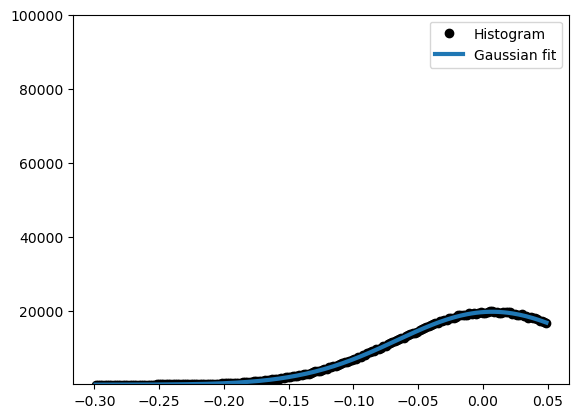

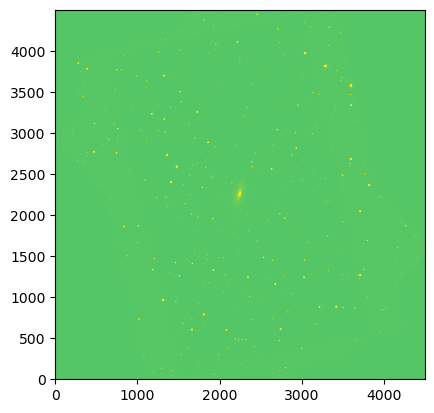

In [5]:
#Read rband image
combinepath='./data/Redux/Combined/'

rband_ima = fits.open(combinepath+'/Combined_NGC7331_R.fits')

ima = rband_ima[0].data
stdboot = np.sqrt(rband_ima[1].data)

fcalmean = 6.566E-17/1e-17
Texp = 300
Nexp = 33

histo, bin_edges = np.histogram(ima[1500:3000,1500:3000].flatten(), bins=200, range=(-0.3,0.05))
#Fit a gaussian to this an histogram
x = 0.5 * (bin_edges[:-1] + bin_edges[1:])
y = histo

print(len(x), len(y))

from astropy.modeling import models, fitting

# Initial guess for the Gaussian
g_init = models.Gaussian1D(amplitude=y.max(), mean=x[np.argmax(y)], stddev=0.04)

# Use a least-squares fitter
fit_g = fitting.LevMarLSQFitter()

# Perform fit
g = fit_g(g_init, x, y)

print("Amplitude:", g.amplitude.value)
print("Mean:", g.mean.value)
print("Stddev:", g.stddev.value)

mp.plot(x, y, 'ko', label='Histogram')
mp.plot(x, g(x), label='Gaussian fit', lw=3)
mp.yscale('linear')
mp.ylim(1e2,1e5)
mp.legend()
mp.show()

std = g.stddev.value

stdima = np.zeros_like(ima)+std

sourcepixels = (ima>4*std)

threshsource = np.zeros_like(ima)
#Thresholded image in physical units
threshsource[sourcepixels] = ima[sourcepixels]
#Thresholded image in electrons
threshsource = threshsource / (fcalmean) * (Texp * Nexp)
#Go to std in e- and the in physical units
stdsource = np.sqrt(threshsource) / (Texp * Nexp) * (fcalmean)

'''
threshsource2 = np.zeros_like(ima)
#Thresholded image in physical units
threshsource2[sourcepixels] = ima[sourcepixels]
stdsource2 = np.sqrt(threshsource2) * np.sqrt((fcalmean)/ (Texp * Nexp))
'''

stdtot = np.sqrt(stdima**2+stdsource**2)

mp.imshow(stdtot, origin='lower', clim=(0,0.1))

hdu = fits.PrimaryHDU(stdtot)
hdu2 = fits.ImageHDU(stdsource)
hdu3 = fits.ImageHDU(stdima)
hdu4 = fits.ImageHDU(stdboot)

hdulist = fits.HDUList([hdu, hdu2, hdu3, hdu4])
hdulist.writeto('STDtests.fits', overwrite=True)

